## Preparing Data for Clustering

In [4]:
# Libraries
import pandas as pd
pd.set_option('display.max_colwidth', 500)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import _pickle as pickle
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler

# Loading in the cleaned DF
with open("./numuser_data.pkl",'rb') as fp:
    df = pickle.load(fp)

In [5]:
# Instantiating the Scaler
scaler = MinMaxScaler()

# Scaling the categories then replacing the old values
df = df[['Bios']].join(pd.DataFrame(scaler.fit_transform(df.drop('Bios', axis=1)), columns=df.columns[1:], index=df.index))
df

,Bios,Location,Interested in,Age,Movies,Music,Sports,Politics,Social Media
0,Social media geek. Freelance alcohol aficionado. Professional internet specialist. Avid writer.,0.444444,0.000000,0.222222,1.000000,0.555556,0.555556,0.000000,0.888889
1,Explorer. Incurable social media evangelist. Problem solver. Freelance pop culture junkie.,1.000000,0.111111,0.444444,1.000000,0.222222,0.000000,1.000000,0.555556
2,Friendly social media nerd. Beer guru. Future teen idol. Pop culture fanatic. Zombie enthusiast.,0.444444,0.333333,0.888889,1.000000,0.222222,0.888889,0.222222,1.000000
3,Beer enthusiast. Creator. Friendly bacon ninja. Extreme gamer. Total student. Wannabe travel geek. Unapologetic tv aficionado.,0.111111,0.888889,0.222222,0.777778,0.111111,1.000000,0.888889,0.888889
4,Lifelong communicator. Pop culture fanatic. Web fanatic. Proud creator. Reader. Certified writer.,0.222222,0.555556,0.111111,0.111111,0.555556,0.555556,0.000000,0.111111
...,...,...,...,...,...,...,...,...,...
4735,Total entrepreneur. Internet buff. Freelance beer ninja. Amateur student. Twitter maven. Tv specialist. General travel advocate. Coffee practitioner.,0.555556,0.000000,0.333333,0.000000,0.111111,0.111111,1.000000,0.444444
4736,Award-winning organizer. Future teen idol. Subtly charming creator. Music maven. Typical food junkie. Falls down a lot. Alcohol specialist.,0.000000,0.111111,0.666667,0.222222,0.333333,0.666667,0.222222,0.333333
4737,Entrepreneur. Coffee fanatic. Bacon nerd. Communicator. Prone to fits of apathy. Unapologetic zombie guru. Travel scholar. Writer.,0.666667,0.777778,0.555556,0.444444,0.555556,0.777778,0.777778,0.888889
4738,Certified explorer. Travel trailblazer. Friend of animals everywhere. Incurable alcohol enthusiast.,0.000000,0.777778,0.777778,0.444444,0.333333,0.222222,0.111111,0.666667


## Vectorizing the Bios
Experimenting with two vectorisation approaches, namely, Count Vectorization and TFIDF Vectorization

In [6]:
# Instantiating the Vectorizer, experimenting with both
vectorizer = CountVectorizer()
#vectorizer = TfidfVectorizer()

# Fitting the vectorizer to the Bios
x = vectorizer.fit_transform(df['Bios'])

# Creating a new DF that contains the vectorized words
df_wrds = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names())

# Concating the words DF with the original DF
newer_df = pd.concat([df, df_wrds], axis=1)

# Dropping the Bios because it is no longer needed in place of vectorization
newer_df.drop('Bios', axis=1, inplace=True)

## Principle Component Ananlysis on DF

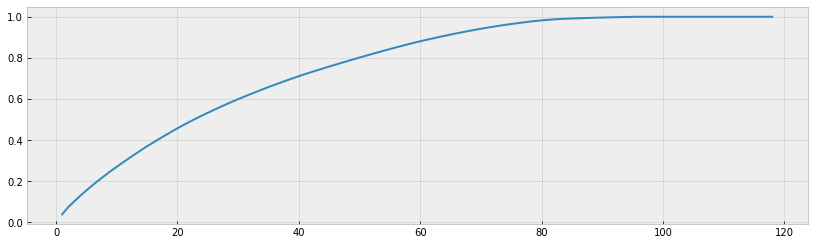

Number features: 71
Total Variance Explained: 0.9514987651415916
0.9466747332412631


In [7]:
# Importing the library
from sklearn.decomposition import PCA

# Instantiating PCA
pca = PCA()

# Fitting and Transforming the DF
df_pca = pca.fit_transform(newer_df)

# Plotting to determine how many features should the dataset be reduced to
plt.style.use("bmh")
plt.figure(figsize=(14,4))
plt.plot(range(1,newer_df.shape[1]+1), pca.explained_variance_ratio_.cumsum())
plt.show()

# Finding the exact number of features that explain at least 95% of the variance in the dataset
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance>=.95])
n_to_reach_95 = newer_df.shape[1] - n_over_95

# Printing out the number of features needed to retain 95% variance
print(f"Number features: {n_to_reach_95}\nTotal Variance Explained: {total_explained_variance[n_to_reach_95]}")

# Reducing the dataset to the number of features determined before
pca = PCA(n_components=n_to_reach_95)

# Fitting and transforming the dataset to the stated number of features and creating a new DF
df_pca = pca.fit_transform(newer_df)

# Seeing the variance ratio that still remains after the dataset has been reduced
print(pca.explained_variance_ratio_.cumsum()[-1])

## Clustering the User Profiles

### Finding the Right Number of Clusters

In [8]:
# Setting the amount of clusters to test out
cluster_cnt = [i for i in range(2, 20, 1)]

# Establishing empty lists to store the scores for the evaluation metrics
s_scores = []

db_scores = []

# Looping through different iterations for the number of clusters
for i in cluster_cnt:
    
    # Hierarchical Agglomerative Clustering with different number of clusters
    hac = AgglomerativeClustering(n_clusters=i)
    
    hac.fit(df_pca)
    
    cluster_assignments = hac.labels_
    
    ## KMeans Clustering with different number of clusters
    #k_means = KMeans(n_clusters=i)
    
    #k_means.fit(df_pca)
    
    #cluster_assignments = k_means.predict(df_pca)
    
    # Appending the scores to the empty lists    
    s_scores.append(silhouette_score(df_pca, cluster_assignments))
    
    db_scores.append(davies_bouldin_score(df_pca, cluster_assignments))

### Evaluating Clusters

Max Value:
Cluster #     Cluster Score
19       0.059081

Min Value:
Cluster #    Cluster Score
3       0.027649


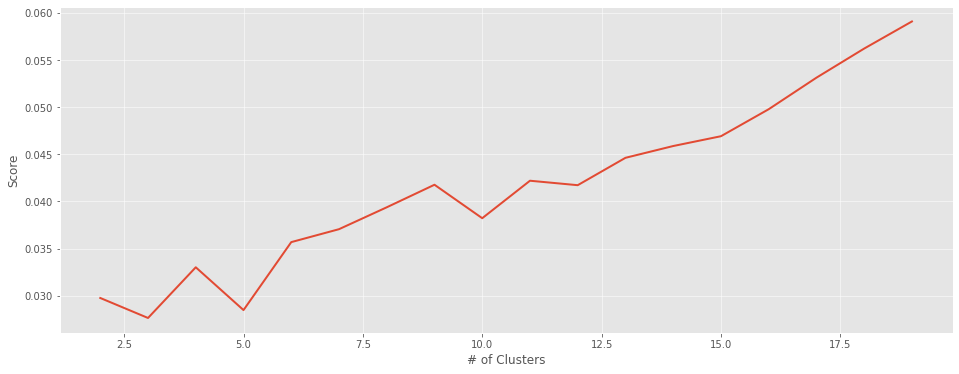

Max Value:
Cluster #    Cluster Score
2       5.187634

Min Value:
Cluster #     Cluster Score
18       3.440007


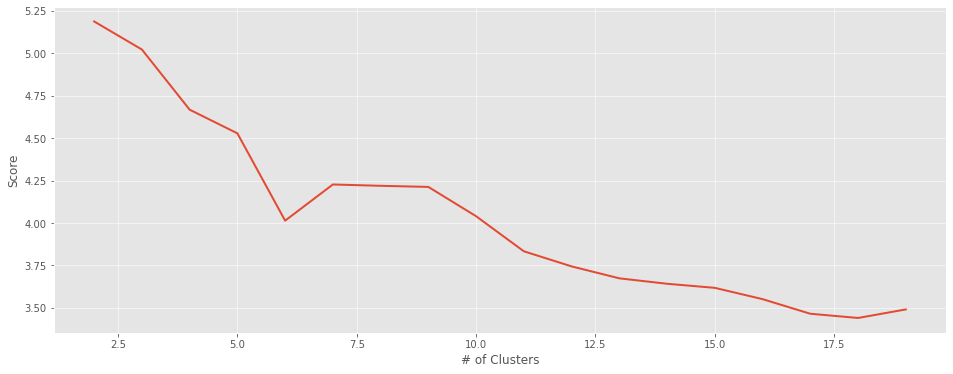

In [9]:
def plot_evaluation(y, x=cluster_cnt):
    """
    Plots the scores of a set evaluation metric. Prints out the max and min values of the evaluation scores.
    """
    
    # Creating a DataFrame for returning the max and min scores for each cluster
    df = pd.DataFrame(columns=['Cluster Score'], index=[i for i in range(2, len(y)+2)])
    df['Cluster Score'] = y
    
    print('Max Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].max()])
    print('\nMin Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].min()])
    
    # Plotting out the scores based on cluster count
    plt.figure(figsize=(16,6))
    plt.style.use('ggplot')
    plt.plot(x,y)
    plt.xlabel('# of Clusters')
    plt.ylabel('Score')
    plt.show()
    
# Running the function on the list of scores
plot_evaluation(s_scores)

plot_evaluation(db_scores)

### Final Clustering Algorithm

In [10]:
# Instantiating HAC
hac = AgglomerativeClustering(n_clusters=12)

# Fitting
hac.fit(df_pca)

# Getting cluster assignments
cluster_assignments = hac.labels_

# Unscaling the categories then replacing the scaled values
df = df[['Bios']].join(pd.DataFrame(scaler.inverse_transform(df.drop('Bios', axis=1)), columns=df.columns[1:], index=df.index))

# Assigning the clusters to each profile
df['Cluster #'] = cluster_assignments

# Viewing the profiles with cluster assignments
df

,Bios,Location,Interested in,Age,Movies,Music,Sports,Politics,Social Media,Cluster #
0,Social media geek. Freelance alcohol aficionado. Professional internet specialist. Avid writer.,4.0,0.0,2.0,9.0,5.0,5.0,0.0,8.0,7
1,Explorer. Incurable social media evangelist. Problem solver. Freelance pop culture junkie.,9.0,1.0,4.0,9.0,2.0,0.0,9.0,5.0,3
2,Friendly social media nerd. Beer guru. Future teen idol. Pop culture fanatic. Zombie enthusiast.,4.0,3.0,8.0,9.0,2.0,8.0,2.0,9.0,3
3,Beer enthusiast. Creator. Friendly bacon ninja. Extreme gamer. Total student. Wannabe travel geek. Unapologetic tv aficionado.,1.0,8.0,2.0,7.0,1.0,9.0,8.0,8.0,8
4,Lifelong communicator. Pop culture fanatic. Web fanatic. Proud creator. Reader. Certified writer.,2.0,5.0,1.0,1.0,5.0,5.0,0.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...
4735,Total entrepreneur. Internet buff. Freelance beer ninja. Amateur student. Twitter maven. Tv specialist. General travel advocate. Coffee practitioner.,5.0,0.0,3.0,0.0,1.0,1.0,9.0,4.0,0
4736,Award-winning organizer. Future teen idol. Subtly charming creator. Music maven. Typical food junkie. Falls down a lot. Alcohol specialist.,0.0,1.0,6.0,2.0,3.0,6.0,2.0,3.0,8
4737,Entrepreneur. Coffee fanatic. Bacon nerd. Communicator. Prone to fits of apathy. Unapologetic zombie guru. Travel scholar. Writer.,6.0,7.0,5.0,4.0,5.0,7.0,7.0,8.0,6
4738,Certified explorer. Travel trailblazer. Friend of animals everywhere. Incurable alcohol enthusiast.,0.0,7.0,7.0,4.0,3.0,2.0,1.0,6.0,10


In [18]:
# Assigning the clusters to each profile
df['Cluster #'] = cluster_assignments

# Viewing the dating profiles with cluster assignments
df

,Bios,Location,Interested in,Age,Movies,Music,Sports,Politics,Social Media,Cluster #
0,Social media geek. Freelance alcohol aficionado. Professional internet specialist. Avid writer.,4.0,0.0,2.0,9.0,5.0,5.0,0.0,8.0,7
1,Explorer. Incurable social media evangelist. Problem solver. Freelance pop culture junkie.,9.0,1.0,4.0,9.0,2.0,0.0,9.0,5.0,3
2,Friendly social media nerd. Beer guru. Future teen idol. Pop culture fanatic. Zombie enthusiast.,4.0,3.0,8.0,9.0,2.0,8.0,2.0,9.0,3
3,Beer enthusiast. Creator. Friendly bacon ninja. Extreme gamer. Total student. Wannabe travel geek. Unapologetic tv aficionado.,1.0,8.0,2.0,7.0,1.0,9.0,8.0,8.0,8
4,Lifelong communicator. Pop culture fanatic. Web fanatic. Proud creator. Reader. Certified writer.,2.0,5.0,1.0,1.0,5.0,5.0,0.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...
4735,Total entrepreneur. Internet buff. Freelance beer ninja. Amateur student. Twitter maven. Tv specialist. General travel advocate. Coffee practitioner.,5.0,0.0,3.0,0.0,1.0,1.0,9.0,4.0,0
4736,Award-winning organizer. Future teen idol. Subtly charming creator. Music maven. Typical food junkie. Falls down a lot. Alcohol specialist.,0.0,1.0,6.0,2.0,3.0,6.0,2.0,3.0,8
4737,Entrepreneur. Coffee fanatic. Bacon nerd. Communicator. Prone to fits of apathy. Unapologetic zombie guru. Travel scholar. Writer.,6.0,7.0,5.0,4.0,5.0,7.0,7.0,8.0,6
4738,Certified explorer. Travel trailblazer. Friend of animals everywhere. Incurable alcohol enthusiast.,0.0,7.0,7.0,4.0,3.0,2.0,1.0,6.0,10


In [19]:
#exporting clustered profiles
with open("./clustered_profiles.pkl", "wb") as fp:
    pickle.dump(df, fp)

## Finding Users within their own Clusters
Sorting users so they match or are recommended to other similar users.

Randomly using one of the clusters:

In [21]:
import random

# Randomly choosing a cluster
rand_cluster = random.choice(df['Cluster #'].unique())

# Assigning the Cluster Profiles as a new DF
group = df[df['Cluster #']==rand_cluster].drop('Cluster #', axis=1)

#viewing newly created DF
group


#print("\nThe most similar user to User #", random_user, "is User #", top_10_sim.index[0])

,Bios,Location,Interested in,Age,Movies,Music,Sports,Politics,Social Media
6,Certified internet guru. Pop culture specialist. Alcohol fanatic. Student. Hardcore bacon nerd.,9.0,0.0,0.0,8.0,7.0,6.0,3.0,2.0
14,Alcohol maven. Devoted writer. Music expert. Evil internet guru. Bacon fan. Zombie geek. Incurable entrepreneur.,6.0,3.0,1.0,3.0,3.0,9.0,5.0,3.0
21,Certified internet guru. Pop culture specialist. Alcohol fanatic. Student. Hardcore bacon nerd.,7.0,3.0,4.0,0.0,9.0,2.0,2.0,8.0
29,Alcohol maven. Devoted writer. Music expert. Evil internet guru. Bacon fan. Zombie geek. Incurable entrepreneur.,1.0,7.0,7.0,4.0,8.0,8.0,0.0,1.0
36,Certified internet guru. Pop culture specialist. Alcohol fanatic. Student. Hardcore bacon nerd.,0.0,9.0,4.0,3.0,0.0,5.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...
4703,Passionate twitter advocate. Food specialist. Bacon trailblazer. Alcohol ninja. Travel scholar.,0.0,7.0,6.0,1.0,6.0,9.0,4.0,3.0
4715,Bacon maven. Freelance twitteraholic. Unapologetic food practitioner. Hardcore alcohol lover. Extreme entrepreneur.,1.0,6.0,0.0,4.0,7.0,2.0,8.0,5.0
4718,Passionate twitter advocate. Food specialist. Bacon trailblazer. Alcohol ninja. Travel scholar.,1.0,0.0,5.0,5.0,0.0,7.0,2.0,9.0
4730,Bacon maven. Freelance twitteraholic. Unapologetic food practitioner. Hardcore alcohol lover. Extreme entrepreneur.,0.0,7.0,9.0,7.0,9.0,4.0,3.0,6.0


## Vectorizing Bios in Selected Cluster

In [22]:
# Fitting the vectorizer to the Bios
cluster_x = vectorizer.fit_transform(group['Bios'])

# Creating a new DF that contains the vectorized words
cluster_v = pd.DataFrame(cluster_x.toarray(), index=group.index, columns=vectorizer.get_feature_names())
cluster_v

,advocate,aficionado,alcohol,amateur,analyst,avid,award,bacon,baconaholic,beer,buff,certified,charming,coffee,communicator,creator,culture,cultureaholic,devoted,enthusiast,entrepreneur,evangelist,evil,expert,explorer,extreme,fan,fanatic,food,foodaholic,freelance,friendly,future,gamer,geek,general,guru,hardcore,hipster,idol,...,internet,internetaholic,introvert,junkie,lifelong,lover,maven,media,mediaholic,music,nerd,ninja,organizer,passionate,pop,practitioner,proud,reader,scholar,social,specialist,student,subtly,teen,thinker,total,trailblazer,travel,travelaholic,troublemaker,tv,twitter,twitteraholic,typical,unapologetic,wannabe,web,winning,writer,zombie
6,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
21,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
36,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4703,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0
4715,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
4718,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0
4730,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0


In [23]:
# Joining the vector DF and the original DF
group = group.join(cluster_v)

# Dropping the Bios because it is no longer needed in place of vectorization
group.drop('Bios', axis=1, inplace=True)

# Viewing the new DF
group

,Location,Interested in,Age,Movies,Music,Sports,Politics,Social Media,advocate,aficionado,alcohol,amateur,analyst,avid,award,bacon,baconaholic,beer,buff,certified,charming,coffee,communicator,creator,culture,cultureaholic,devoted,enthusiast,entrepreneur,evangelist,evil,expert,explorer,extreme,fan,fanatic,food,foodaholic,freelance,friendly,...,internet,internetaholic,introvert,junkie,lifelong,lover,maven,media,mediaholic,music,nerd,ninja,organizer,passionate,pop,practitioner,proud,reader,scholar,social,specialist,student,subtly,teen,thinker,total,trailblazer,travel,travelaholic,troublemaker,tv,twitter,twitteraholic,typical,unapologetic,wannabe,web,winning,writer,zombie
6,9.0,0.0,0.0,8.0,7.0,6.0,3.0,2.0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14,6.0,3.0,1.0,3.0,3.0,9.0,5.0,3.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
21,7.0,3.0,4.0,0.0,9.0,2.0,2.0,8.0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29,1.0,7.0,7.0,4.0,8.0,8.0,0.0,1.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
36,0.0,9.0,4.0,3.0,0.0,5.0,3.0,2.0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4703,0.0,7.0,6.0,1.0,6.0,9.0,4.0,3.0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0
4715,1.0,6.0,0.0,4.0,7.0,2.0,8.0,5.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,...,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
4718,1.0,0.0,5.0,5.0,0.0,7.0,2.0,9.0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0
4730,0.0,7.0,9.0,7.0,9.0,4.0,3.0,6.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,...,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0


## Finding Correlation Among Users

In [24]:
# Trasnposing the DF so that we are correlating with the index(users)
corr_group = group.T.corr()

corr_group

,6,14,21,29,36,44,51,59,66,74,81,89,96,104,111,119,126,134,141,149,156,164,171,179,186,194,600,604,612,613,615,619,627,628,630,634,642,643,645,649,...,4354,4369,4384,4399,4414,4429,4444,4459,4474,4489,4504,4519,4535,4538,4550,4553,4565,4568,4580,4583,4595,4598,4610,4613,4625,4628,4640,4643,4655,4658,4670,4673,4685,4688,4700,4703,4715,4718,4730,4733
6,1.000000,0.776012,0.662865,0.539476,0.328554,0.565399,0.561052,0.663000,0.310110,0.585809,0.731015,0.775326,0.746049,0.724834,0.720611,0.580740,0.851857,0.576166,0.524679,0.487314,0.696804,0.547943,0.743793,0.660564,0.587056,0.765437,0.832986,0.834668,0.674371,0.406858,0.707789,0.788826,0.647285,0.554831,0.581817,0.759209,0.603957,0.671926,0.358818,0.702016,...,0.511871,0.508626,0.751512,0.571779,0.670295,0.640150,0.755955,0.651458,0.362972,0.548791,0.564800,0.610218,0.673087,0.566757,0.545165,0.543976,0.427099,0.731396,0.588831,0.794266,0.683401,0.851567,0.840887,0.522566,0.255025,0.550571,0.635585,0.572300,0.692953,0.562746,0.105371,0.742482,0.558777,0.540840,0.712790,0.451188,0.559569,0.478572,0.524032,0.663776
14,0.776012,1.000000,0.593675,0.674134,0.583896,0.768444,0.744377,0.772376,0.556384,0.752508,0.809261,0.692581,0.655108,0.777898,0.886700,0.777914,0.867685,0.659376,0.541118,0.625021,0.606714,0.631991,0.757768,0.580871,0.543404,0.777400,0.767268,0.638607,0.798061,0.661420,0.770291,0.795212,0.720221,0.607425,0.616389,0.688564,0.787548,0.756358,0.611108,0.567455,...,0.789840,0.657693,0.768600,0.620559,0.797354,0.727696,0.721446,0.682738,0.562085,0.604232,0.612784,0.566227,0.664680,0.644801,0.670241,0.623258,0.661322,0.729028,0.637129,0.808827,0.791728,0.813438,0.850961,0.696363,0.368552,0.796391,0.681442,0.704497,0.740617,0.794535,0.343150,0.731833,0.761606,0.575526,0.790434,0.709615,0.623486,0.615197,0.538651,0.567493
21,0.662865,0.593675,1.000000,0.581803,0.386842,0.776757,0.470175,0.666576,0.367810,0.835667,0.510306,0.868162,0.326982,0.794612,0.605484,0.581608,0.802633,0.658774,0.845136,0.522438,0.732486,0.524859,0.409347,0.569582,0.648437,0.826303,0.661301,0.670949,0.682804,0.656115,0.786239,0.644989,0.452137,0.580913,0.464259,0.576833,0.411851,0.788421,0.595592,0.745939,...,0.574770,0.763927,0.723703,0.637634,0.491369,0.865975,0.401208,0.596749,0.716503,0.653915,0.771841,0.497754,0.689606,0.697604,0.665123,0.512337,0.675707,0.406094,0.832602,0.594467,0.856287,0.554315,0.645724,0.435418,0.750038,0.660841,0.688301,0.659586,0.627006,0.611830,0.326009,0.670072,0.700497,0.709749,0.655921,0.593799,0.640502,0.506368,0.686112,0.580243
29,0.539476,0.674134,0.581803,1.000000,0.709912,0.600223,0.652965,0.616836,0.760032,0.763568,0.653515,0.685953,0.512763,0.625849,0.548216,0.740274,0.631029,0.743612,0.506780,0.675242,0.599347,0.683804,0.567809,0.661259,0.490850,0.567269,0.514510,0.596013,0.779068,0.662837,0.709069,0.617382,0.594345,0.506384,0.705948,0.635354,0.614546,0.682091,0.354718,0.759166,...,0.800951,0.625117,0.621059,0.696681,0.635060,0.662663,0.766621,0.400087,0.647776,0.538880,0.721943,0.508010,0.824897,0.415828,0.529582,0.653030,0.638212,0.666037,0.609528,0.657765,0.807947,0.611277,0.790095,0.560819,0.552645,0.603681,0.178940,0.239375,0.898163,0.671745,0.711807,0.489118,0.610304,0.721233,0.720974,0.870298,0.555092,0.494826,0.847997,0.374234
36,0.328554,0.583896,0.386842,0.709912,1.000000,0.583277,0.918063,0.608535,0.824744,0.706878,0.780521,0.251039,0.632019,0.507469,0.755479,0.755706,0.480331,0.644613,0.593107,0.426101,0.647637,0.713520,0.628666,0.552399,0.591513,0.211332,0.435584,0.345072,0.770245,0.818074,0.640247,0.491628,0.466723,0.670463,0.470370,0.535628,0.726902,0.544219,0.460780,0.455178,...,0.872621,0.633292,0.425064,0.751290,0.754539,0.497531,0.613471,0.576817,0.730168,0.437723,0.688880,0.604543,0.716963,0.556751,0.527455,0.695459,0.653516,0.682377,0.555861,0.628280,0.610923,0.534876,0.591676,0.824778,0.493793,0.723296,0.178224,0.349590,0.780902,0.799363,0.827487,0.606330,0.568045,0.664616,0.701903,0.785632,0.584420,0.506653,0.686053,0.518833
...,...,...,...

## Finding Top 10 Similar Users for a Profile

In [25]:
random_user = random.choice(corr_group.index)

print("Top 10 most similar users to User #", random_user, '\n')

top_10_sim = corr_group[[random_user]].sort_values(by=[random_user],axis=0, ascending=False)[1:11]

print(top_10_sim)

print("\nThe most similar user to User #", random_user, "is User #", top_10_sim.index[0])

Top 10 most similar users to User # 21 

            21
4286  0.907545
3045  0.899527
3774  0.896069
4120  0.892841
2725  0.886466
1262  0.883923
1401  0.879215
3158  0.871677
2882  0.871454
89    0.868162

The most similar user to User # 21 is User # 4286
